---
title: Surface Ocean heat from CESM2 LENS data
author: Harsha R. Hampapura
---

## Calculate surface ocean heat content using CESM2 LENS data on a Jetstream 2 exosphere instance
### Table of Contents
- [Section 1: Introduction](#Section-1:-Introduction) 
- [Section 2: Select Dask Cluster](#Section-2:-Select-Dask-Cluster) 
- [Section 3: Data Loading](#Section-3:-Data-Loading) 
- [Section 4: Data Analysis](#Section-4:-Data-Analysis)  

- This notebook is adapted from the NCAR gallery in the Pangeo collection
- https://gallery.pangeo.io/repos/NCAR/notebook-gallery/notebooks/Run-Anywhere/Ocean-Heat-Content/OHC_tutorial.html

## Section 1: Introduction
### Input Data Access

- This notebook illustrates how to compute surface ocean heat content using potential temperature data from CESM2 Large Ensemble Dataset (https://www.cesm.ucar.edu/community-projects/lens2) hosted on NCAR's GDEX.
- This data is open access and is accessed via OSDF

In [1]:
# Imports
import intake
import numpy as np
import pandas as pd
import xarray as xr
# import seaborn as sns
import re
import os
import matplotlib.pyplot as plt
import dask
from dask.distributed import LocalCluster
import cf_units as cf

In [2]:
init_year0  = '1991'
init_year1  = '2020'
final_year0 = '2071'
final_year1 = '2100'

In [3]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")

In [4]:
# Set up your sratch folder path
# username       = os.environ["USER"]
# scratch  = "/" + username
# print(scratch)
#
catalog_url = 'https://osdata.gdex.ucar.edu/d010092/catalogs/d010092-osdf.json'

## Section 2: Set up Dask Cluster
- Setting up a dask cluster. 
- The default will be LocalCluster as that can run on any system.

In [5]:
cluster = LocalCluster()
client = cluster.get_client()

In [6]:
# Scale the local cluster
n_workers = 5
cluster.scale(n_workers)
cluster

LocalCluster(6a7597d5, 'tcp://127.0.0.1:38069', workers=4, threads=4, memory=14.63 GiB)

## Section 3: Data Loading
- Load CESM2 LENS zarr data from GDEX using an intake-ESM catalog
- For more details regarding the dataset. See, https://gdex.ucar.edu/datasets/d010092/#

In [7]:
cesm_cat = intake.open_esm_datastore(catalog_url)
cesm_cat

,unique
,322
variable,54
long_name,52
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,4
spatial_domain,3
units,21


In [8]:
# cesm_cat.df['variable'].values

In [9]:
%pip show zarr

Name: zarr
Version: 3.1.5
Summary: An implementation of chunked, compressed, N-dimensional arrays for Python
Home-page: https://github.com/zarr-developers/zarr-python
Author: 
Author-email: Alistair Miles <alimanfoo@googlemail.com>
License-Expression: MIT
Location: /home/exouser/.conda/envs/osdf/lib/python3.11/site-packages
Requires: donfig, google-crc32c, numcodecs, numpy, packaging, typing-extensions
Required-by: intake-esm, kerchunk
Note: you may need to restart the kernel to use updated packages.


In [10]:
cesm_temp = cesm_cat.search(variable ='TEMP', frequency ='monthly',experiment='historical')
cesm_temp

,unique
column_0,1
variable,1
long_name,1
component,1
experiment,1
forcing_variant,1
frequency,1
vertical_levels,1
spatial_domain,1
units,1


In [11]:
cesm_temp.df['path'].values

<ArrowExtensionArray>
['osdf:///ncar-gdex/d010092/ocn/monthly/cesm2LE-historical-cmip6-TEMP.zarr']
Length: 1, dtype: large_string[pyarrow]

:::{note}: Important Note!
Because our environment has zarr version >= 3 and the zarr stores we are trying to open were created using zarr version <3,
we need to force the use of zarr version 2 by passing keyword arguments to the to_dataset_dict() function
:::

In [12]:
dsets_cesm = cesm_temp.to_dataset_dict(xarray_open_kwargs={'engine':'zarr','backend_kwargs':{'consolidated': True,'zarr_format': 2}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


<div><progress max="1" value="1"></progress> 100.00% [1/1 00:05&lt;00:00]</div>

/home/exouser/.conda/envs/osdf/lib/python3.11/site-packages/intake_esm/source.py:109: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 5. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/home/exouser/.conda/envs/osdf/lib/python3.11/site-packages/intake_esm/source.py:109: UserWarning: The specified chunks separate the stored chunks along dimension "z_t" starting at index 57. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/home/exouser/.conda/envs/osdf/lib/python3.11/site-packages/intake_esm/source.py:109: UserWarning: The specified chunks separate the stored chunks along dimension "nlat" starting at index 375. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/home/exouser/.conda/envs/osdf/lib/python3.11/s

In [13]:
cesm_temp.keys()

['ocn.historical.monthly.cmip6']

In [14]:
historical       = dsets_cesm['ocn.historical.monthly.cmip6']
# future_smbb      = dsets_cesm['ocn.ssp370.monthly.smbb']
# future_cmip6     = dsets_cesm['ocn.ssp370.monthly.cmip6']

In [15]:
# %%time
# merge_ds_cmip6 = xr.concat([historical, future_cmip6], dim='time')
# merge_ds_cmip6 = merge_ds_cmip6.dropna(dim='member_id')

In [16]:
historical

<xarray.Dataset> Size: 3TB
Dimensions:     (member_id: 50, time: 1980, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time        (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * z_t         (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    time_bound  (time, d2) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (member_id, time, z_t, nlat, nlon) float32 3TB dask.array<chunksize=(1, 5, 57, 375, 311), meta=np.ndarray>
Attributes: (12/25)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    model_doi_url:                     https://doi.org/10.5065/D67H1H0V
    revision:                          $Id$
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1850-01-16 12:00:00
    intake_esm_attrs:end_time:         2014-12-16 12:00:00
    intake_esm_attrs:path:             osdf:///ncar-gdex/d010092/ocn/monthly/...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.historical.monthly.cmip6

#### Change units

In [17]:
orig_units = cf.Unit(historical.z_t.attrs['units'])
orig_units

Unit('centimeters')

In [18]:
def change_units(ds, variable_str, variable_bounds_str, target_unit_str):
    orig_units = cf.Unit(ds[variable_str].attrs['units'])
    target_units = cf.Unit(target_unit_str)
    variable_in_new_units = xr.apply_ufunc(orig_units.convert, ds[variable_bounds_str], target_units, dask='parallelized', output_dtypes=[ds[variable_bounds_str].dtype])
    return variable_in_new_units

In [19]:
historical['z_t']

<xarray.DataArray 'z_t' (z_t: 60)> Size: 240B
array([5.000000e+02, 1.500000e+03, 2.500000e+03, 3.500000e+03, 4.500000e+03,
       5.500000e+03, 6.500000e+03, 7.500000e+03, 8.500000e+03, 9.500000e+03,
       1.050000e+04, 1.150000e+04, 1.250000e+04, 1.350000e+04, 1.450000e+04,
       1.550000e+04, 1.650984e+04, 1.754790e+04, 1.862913e+04, 1.976603e+04,
       2.097114e+04, 2.225783e+04, 2.364088e+04, 2.513702e+04, 2.676542e+04,
       2.854837e+04, 3.051192e+04, 3.268680e+04, 3.510935e+04, 3.782276e+04,
       4.087846e+04, 4.433777e+04, 4.827367e+04, 5.277280e+04, 5.793729e+04,
       6.388626e+04, 7.075633e+04, 7.870025e+04, 8.788252e+04, 9.847059e+04,
       1.106204e+05, 1.244567e+05, 1.400497e+05, 1.573946e+05, 1.764003e+05,
       1.968944e+05, 2.186457e+05, 2.413972e+05, 2.649001e+05, 2.889385e+05,
       3.133405e+05, 3.379793e+05, 3.627670e+05, 3.876452e+05, 4.125768e+05,
       4.375392e+05, 4.625190e+05, 4.875083e+05, 5.125028e+05, 5.375000e+05],
      dtype=float32)
Coordinates:
  * z_t      (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Attributes:
    long_name:  depth from surface to midpoint of layer
    positive:   down
    units:      centimeters
    valid_max:  537500.0
    valid_min:  500.0

In [20]:
depth_levels_in_m = change_units(historical, 'z_t', 'z_t', 'm')
hist_temp_in_degK = change_units(historical, 'TEMP', 'TEMP', 'degK')
# fut_cmip6_temp_in_degK = change_units(future_cmip6, 'TEMP', 'TEMP', 'degK')
# fut_smbb_temp_in_degK = change_units(future_smbb, 'TEMP', 'TEMP', 'degK')
#
hist_temp_in_degK  = hist_temp_in_degK.assign_coords(z_t=("z_t", depth_levels_in_m['z_t'].data))
hist_temp_in_degK["z_t"].attrs["units"] = "m"
hist_temp_in_degK

<xarray.DataArray 'TEMP' (member_id: 50, time: 1980, z_t: 60, nlat: 384,
                          nlon: 320)> Size: 3TB
dask.array<transpose, shape=(50, 1980, 60, 384, 320), dtype=float32, chunksize=(1, 5, 57, 375, 311), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * z_t        (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

In [21]:
depth_levels_in_m.isel(z_t=slice(0, -1))

<xarray.DataArray 'z_t' (z_t: 59)> Size: 236B
array([5.0000000e+00, 1.5000000e+01, 2.5000000e+01, 3.5000000e+01,
       4.5000000e+01, 5.5000000e+01, 6.5000000e+01, 7.5000000e+01,
       8.5000000e+01, 9.5000000e+01, 1.0500000e+02, 1.1500000e+02,
       1.2500000e+02, 1.3500000e+02, 1.4500000e+02, 1.5500000e+02,
       1.6509840e+02, 1.7547905e+02, 1.8629128e+02, 1.9766028e+02,
       2.0971138e+02, 2.2257828e+02, 2.3640883e+02, 2.5137016e+02,
       2.6765421e+02, 2.8548364e+02, 3.0511923e+02, 3.2686798e+02,
       3.5109348e+02, 3.7822763e+02, 4.0878464e+02, 4.4337769e+02,
       4.8273672e+02, 5.2772803e+02, 5.7937286e+02, 6.3886261e+02,
       7.0756329e+02, 7.8700250e+02, 8.7882526e+02, 9.8470587e+02,
       1.1062042e+03, 1.2445669e+03, 1.4004972e+03, 1.5739464e+03,
       1.7640033e+03, 1.9689442e+03, 2.1864565e+03, 2.4139717e+03,
       2.6490012e+03, 2.8893848e+03, 3.1334048e+03, 3.3797935e+03,
       3.6276704e+03, 3.8764519e+03, 4.1257681e+03, 4.3753926e+03,
       4.6251904e+03, 4.8750835e+03, 5.1250283e+03], dtype=float32)
Coordinates:
  * z_t      (z_t) float32 236B 500.0 1.5e+03 2.5e+03 ... 4.875e+05 5.125e+05
Attributes:
    long_name:  depth from surface to midpoint of layer
    positive:   down
    units:      centimeters
    valid_max:  537500.0
    valid_min:  500.0

In [22]:
#Compute depth level deltas using z_t levels
depth_level_deltas = depth_levels_in_m.isel(z_t=slice(1, None)).values - depth_levels_in_m.isel(z_t=slice(0, -1)).values
# Optionally, if you want to keep it as an xarray DataArray, re-wrap the result
depth_level_deltas = xr.DataArray(depth_level_deltas, dims=["z_t"], coords={"z_t": depth_levels_in_m.z_t.isel(z_t=slice(0, -1))})
depth_level_deltas                                                                                        

<xarray.DataArray (z_t: 59)> Size: 236B
array([ 10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.098404,  10.380646,  10.812225,  11.369003,  12.051102,
        12.866898,  13.830551,  14.961334,  16.284042,  17.829437,
        19.63559 ,  21.748749,  24.225494,  27.134155,  30.557007,
        34.59305 ,  39.35904 ,  44.991302,  51.644836,  59.489746,
        68.70068 ,  79.43921 ,  91.822754, 105.880615, 121.49835 ,
       138.36267 , 155.9303  , 173.44922 , 190.05688 , 204.94092 ,
       217.51233 , 227.51514 , 235.02954 , 240.38354 , 244.02002 ,
       246.38867 , 247.87695 , 248.7815  , 249.31616 , 249.62451 ,
       249.79785 , 249.89307 , 249.94482 , 249.97168 ], dtype=float32)
Coordinates:
  * z_t      (z_t) float32 236B 500.0 1.5e+03 2.5e+03 ... 4.875e+05 5.125e+05

## Section 4: Data Analysis 
#### Compute Ocean Heat content for ocean surface
- Ocean surface is considered to be the top 100m
- The formula for this is: $$ H = \rho C \int_0^z T(z) dz $$


Where H is ocean heat content, the value we are trying to calculate,

$\rho$ is the density of sea water, $1026 kg/m^3$  ,

$C$ is the specific heat of sea water, $3990 J/(kg K)$  ,

$z$ is the depth limit of the calculation in meters,

and $T(z)$ is the temperature at each depth in degrees Kelvin.

In [23]:
def calc_ocean_heat(delta_level, temperature):
    rho = 1026 #kg/m^3
    c_p = 3990 #J/(kg K)
    weighted_temperature = delta_level * temperature
    heat = weighted_temperature.sum(dim="z_t")*rho*c_p
    return heat

In [24]:
# Remember that the coordinate z_t still has values in cm
hist_temp_ocean_surface = hist_temp_in_degK.where(hist_temp_in_degK['z_t'] < 1e4,drop=True)
hist_temp_ocean_surface

<xarray.DataArray 'TEMP' (member_id: 50, time: 1980, z_t: 10, nlat: 384,
                          nlon: 320)> Size: 487GB
dask.array<where, shape=(50, 1980, 10, 384, 320), dtype=float32, chunksize=(1, 5, 10, 375, 311), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * z_t        (z_t) float32 40B 500.0 1.5e+03 2.5e+03 ... 8.5e+03 9.5e+03
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

In [25]:
depth_level_deltas_surface = depth_level_deltas.where(depth_level_deltas['z_t'] <1e4, drop= True)
depth_level_deltas_surface

<xarray.DataArray (z_t: 10)> Size: 40B
array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.], dtype=float32)
Coordinates:
  * z_t      (z_t) float32 40B 500.0 1.5e+03 2.5e+03 ... 7.5e+03 8.5e+03 9.5e+03

In [26]:
hist_ocean_heat = calc_ocean_heat(depth_level_deltas_surface,hist_temp_ocean_surface)
hist_ocean_heat

<xarray.DataArray (member_id: 50, time: 1980, nlat: 384, nlon: 320)> Size: 49GB
dask.array<mul, shape=(50, 1980, 384, 320), dtype=float32, chunksize=(1, 5, 375, 311), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

### Plot Ocean Heat

In [27]:
%%time
# Jan, 1850 average over all memebers
# hist_ocean_avgheat = hist_ocean_heat.mean('member_id')
hist_ocean_avgheat = hist_ocean_heat.isel({'time':[0,-12]}).mean('member_id')
hist_ocean_avgheat

CPU times: user 34.7 ms, sys: 10.4 ms, total: 45.2 ms
Wall time: 45.7 ms


<xarray.DataArray (time: 2, nlat: 384, nlon: 320)> Size: 983kB
dask.array<mean_agg-aggregate, shape=(2, 384, 320), dtype=float32, chunksize=(2, 375, 311), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 16B 1850-01-16 12:00:00 2014-01-16 12:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

/home/exouser/.conda/envs/osdf/lib/python3.11/site-packages/distributed/client.py:3387: UserWarning: Sending large graph of size 14.27 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 17.5 s, sys: 2.59 s, total: 20.1 s
Wall time: 2min 37s


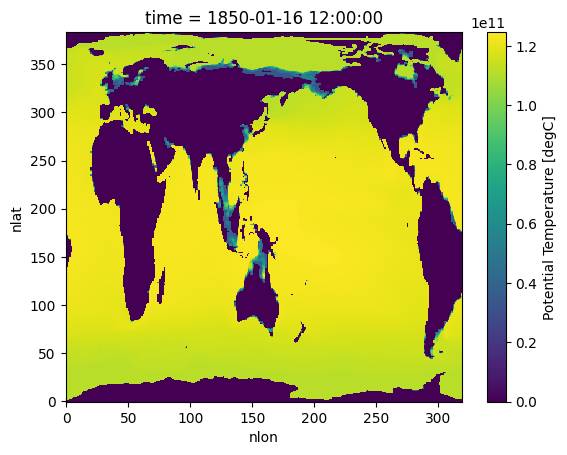

In [28]:
%%time
hist_ocean_avgheat.isel(time=0).plot()

CPU times: user 17 s, sys: 2.31 s, total: 19.3 s
Wall time: 2min 17s


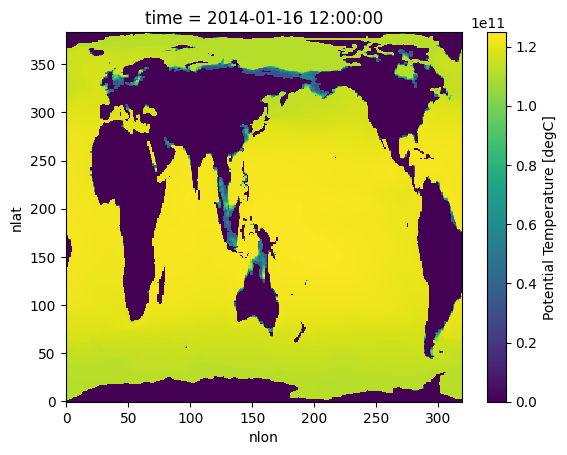

In [29]:
%%time
#Plot ocean heat for Jan 2014
hist_ocean_avgheat.isel(time=1).plot()

### Has the surface ocean heat content increased with time for January ? (Due to Global Warming!)

In [30]:
hist_ocean_avgheat_ano = hist_ocean_avgheat.isel(time=1) - hist_ocean_avgheat.isel(time=0)

/home/exouser/.conda/envs/osdf/lib/python3.11/site-packages/distributed/client.py:3387: UserWarning: Sending large graph of size 14.27 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 18.2 s, sys: 2.65 s, total: 20.9 s
Wall time: 2min 26s


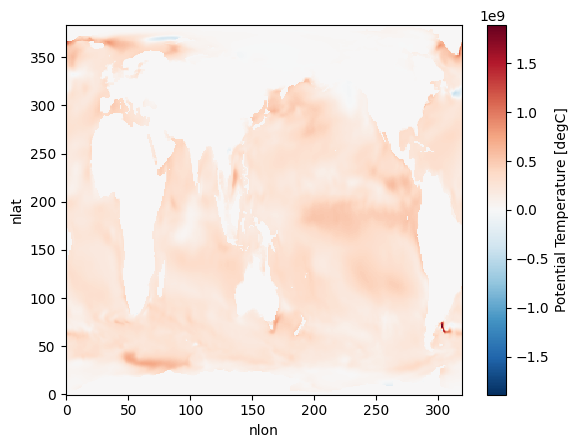

In [31]:
%%time
hist_ocean_avgheat_ano.plot()

In [32]:
cluster.close()